# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
import visualize
import foolbox

import tensorflow as tf

from keras.utils import plot_model
from keras import backend as K

from PIL import Image

%matplotlib inline 
%load_ext autoreload
%autoreload 2

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Importing things inside foolbox


Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 0
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.BATCH_SIZE = 1
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      0
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE           

## Create Model and Load Trained Weights

In [3]:
import importlib
importlib.reload(modellib)

<module 'model' from '/workspace/model.py'>

In [4]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

plot_model(model.keras_model, to_file='/workspace/mask_rcnn_model.png', show_shapes=True)

In [5]:
for o in model.keras_model.output:
    print(o.shape)

(1, 100, 6)
(?, 1000, 81)
(?, 1000, 81, 4)
(?, 100, 28, 28, 81)
(1, ?, 4)
(?, ?, 2)
(?, ?, 4)
(?, 81)


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [6]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


## Select image and mold it to correct shape

Image with size (375, 500, 3) with value range 0-255


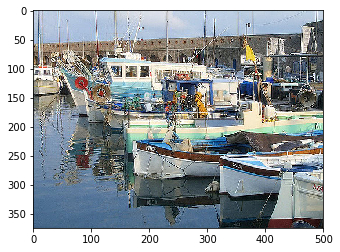

In [7]:
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
print("Image with size {} with value range {}-{}".format(image.shape, np.min(image), np.max(image)))
# new_img_size = (224, 224, 3)
# print("Resizing image to {}...".format(new_img_size))
# PIL_img = Image.fromarray(image)
# image = PIL_img.resize(new_img_size[0:2], Image.NEAREST)
# image = np.array(image)
plt.imshow(image)

molded_images, image_metas, windows = model.mold_inputs([image])
molded_image = molded_images[0]
image_metadata = image_metas[0]
# print("Molded image with size {} with value range {}-{}".format(molded_image.shape, np.min(molded_image), np.max(molded_image)))
# plt.imshow(molded_image)

## Run the CNN on the original image

In [8]:
real_pred = model.keras_model.predict([[molded_image], [image_metadata]])

In [9]:
top_classes = real_pred[7]
original_label = np.argmax(top_classes)
print(original_label)

0


## Generating an image to be misclassified just using noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


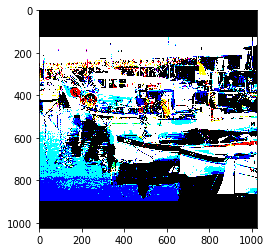

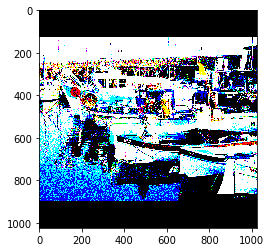

In [10]:
noise_percentage = 0.3
max_noise = (noise_percentage * (np.max(image) - np.min(image)))/2
min_noise = (noise_percentage * (np.max(image) - np.min(image)))/-2
fake_attack = np.clip(np.random.uniform(min_noise, max_noise, image.shape) + image, 0, 255)
fake_molded_images, fake_image_metas, fake_windows = model.mold_inputs([fake_attack])
fake_molded_image = fake_molded_images[0]
fake_image_metadata = fake_image_metas[0]
# print("Molded image with size {} with value range {}-{}".format(fake_molded_image.shape, np.min(fake_molded_image), np.max(fake_molded_image)))
plt.imshow(molded_image)
plt.figure()
plt.imshow(fake_molded_image)

## Generating an adversarial image to be misclassified using an adversarial attack

In [11]:
predictions = model.keras_model.output[7]
print(predictions)
print("============================")
predictions = model.keras_model.output[7].op.inputs
print(predictions)
print("============================")
for inp in predictions:
    print(inp)
# predictions = predictions[0][0][0]
# print(predictions)
# print(K.expand_dims(predictions, axis=0))

Tensor("top_class/Minimum:0", shape=(?, 81), dtype=float32)
Tensor("top_class/Relu:0", shape=(?, 81), dtype=float32)
Tensor("top_class/Const:0", shape=(), dtype=float32)


In [12]:
fModel = foolbox.models.KerasModel(model.keras_model, bounds=(0,255), image_input_idx=0, output_idx=7)
threshold = 0.5
criterion = foolbox.criteria.ConfidentMisclassification(threshold)
attack = foolbox.attacks.FGSM(model=fModel, criterion=criterion)

Shape of predictions is (None, 81)
Number of classes: 81
Predictions_shape: (?, 81)
label_input: Tensor("Placeholder_691:0", shape=(1,), dtype=float32)
predictions: Tensor("top_class/Relu:0", shape=(?, 81), dtype=float32)


/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [13]:
adversarial_img = attack(image, original_label, unpack=True)
adversarial_img_int = adversarial_img.astype(int)
plt.imshow(adversarial_img)

px: (1, 375, 500, 3)


InvalidArgumentError: Incompatible shapes: [1,48,64,256] vs. [1,47,63,256]
	 [[Node: fpn_p3add/add = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](fpn_p4upsampled/ResizeNearestNeighbor, fpn_c3p3/BiasAdd)]]

## Comparing detections from both original and adversarial image

In [ ]:
detections, mrcnn_class, mrcnn_bbox, mrcnn_mask, rois, rpn_class, rpn_bbox, top_classes = real_pred
for detection_cls, output_cls in zip(detections[0], mrcnn_class[0]):
    print("{}: {} ({:.2f}%)\t{}: {} ({:.2f}%)".format(
                                            int(detection_cls[4]), 
                                            class_names[int(detection_cls[4])], 
                                            detection_cls[5]*100,
                                            np.argmax(output_cls), 
                                            class_names[np.argmax(output_cls)],
                                            np.max(output_cls)*100))

In [ ]:
print((mrcnn_class[0,0,:]))
print(np.max(mrcnn_class[0,0,:]))
print(np.argmax(mrcnn_class[0,0,:]))

In [ ]:

fake_real_pred = model.keras_model.predict([[fake_molded_image], [fake_image_metadata]])
fake_detections, fake_mrcnn_class, fake_mrcnn_bbox, fake_mrcnn_mask, fake_rois, fake_rpn_class, fake_rpn_bbox, fake_top_classes = fake_real_pred
top_cls_idx = np.argmax(top_classes)
fake_top_cls_idx = np.argmax(fake_top_classes)
print("{0}: {1:.2f}%\t{2}: {3:.2f}%".format(class_names[top_cls_idx], top_classes[0,top_cls_idx]*100, class_names[fake_top_cls_idx], fake_top_classes[0,fake_top_cls_idx]*100))
print("Real\t\tFake\r\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
for detection, fake_detection in zip(detections[0], fake_detections[0]):
    print("{0}: {1:.2f}%\t{2}: {3:.2f}%".format(class_names[int(detection[4])], detection[5]*100, class_names[int(fake_detection[4])], fake_detection[5]*100))

In [ ]:
# Run detection
results = model.detect([image], verbose=False)
# Visualize results
r = results[0]
# print(r)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

fake_results = model.detect([fake_attack], verbose=False)
# Visualize results
fake_r = fake_results[0]
# print(r)
visualize.display_instances(fake_attack, fake_r['rois'], fake_r['masks'], fake_r['class_ids'], 
                            class_names, fake_r['scores'])